# Persona Vectors: Accurate Repository Implementation

This notebook provides an accurate implementation of **Persona Vectors** that matches the behavior of the `persona_vectors` repository exactly.

**Model**: Qwen/Qwen2.5-7B-Instruct

## Key Implementation Details (Matching Repository)

1. **Steering**: Only steers the **last token** during generation (not all response tokens)
2. **Layer Indexing**: Uses `layer_idx = layer - 1` offset when creating hooks
3. **Tokenization**: Uses `add_special_tokens=False` for hidden state extraction
4. **Architecture-agnostic**: Supports multiple model architectures via `_locate_layer()`

## 1. Setup and Imports

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.notebook import tqdm, trange
import json
import pandas as pd
from typing import List, Dict, Tuple, Optional, Sequence, Union, Iterable
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4090


In [2]:
# Load Qwen2.5-7B-Instruct
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"

print(f"Loading {MODEL_NAME}...")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

print(f"\nModel Architecture:")
print(f"  Hidden size: {model.config.hidden_size}")
print(f"  Number of layers: {model.config.num_hidden_layers}")

Loading Qwen/Qwen2.5-7B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


Model Architecture:
  Hidden size: 3584
  Number of layers: 28


## 2. ActivationSteerer - Exact Repository Implementation

This is copied directly from `persona_vectors/activation_steer.py` with minor adaptations for notebook use.

In [3]:
class ActivationSteerer:
    """
    Add (coeff * steering_vector) to a chosen transformer block's output.
    
    EXACT implementation from persona_vectors/activation_steer.py
    
    Key behaviors:
    - 'all': Add steering to ALL tokens
    - 'prompt': Add steering to all tokens EXCEPT during single-token generation
    - 'response': Add steering ONLY to the LAST token (t[:, -1, :])
    """

    _POSSIBLE_LAYER_ATTRS: Iterable[str] = (
        "transformer.h",       # GPT-2/Neo, Bloom, etc.
        "encoder.layer",       # BERT/RoBERTa
        "model.layers",        # Llama/Mistral/Qwen
        "gpt_neox.layers",     # GPT-NeoX
        "block",               # Flan-T5
    )

    def __init__(
        self,
        model: torch.nn.Module,
        steering_vector: Union[torch.Tensor, Sequence[float]],
        *,
        coeff: float = 1.0,
        layer_idx: int = -1,
        positions: str = "all",
        debug: bool = False,
    ):
        self.model, self.coeff, self.layer_idx = model, float(coeff), layer_idx
        self.positions = positions.lower()
        self.debug = debug
        self._handle = None

        # Build vector
        p = next(model.parameters())
        self.vector = torch.as_tensor(steering_vector, dtype=p.dtype, device=p.device)
        if self.vector.ndim != 1:
            raise ValueError("steering_vector must be 1-D")
        hidden = getattr(model.config, "hidden_size", None)
        if hidden and self.vector.numel() != hidden:
            raise ValueError(
                f"Vector length {self.vector.numel()} != model hidden_size {hidden}"
            )
        # Validate positions
        valid_positions = {"all", "prompt", "response"}
        if self.positions not in valid_positions:
            raise ValueError("positions must be 'all', 'prompt', 'response'")

    def _locate_layer(self):
        """Architecture-agnostic layer location."""
        for path in self._POSSIBLE_LAYER_ATTRS:
            cur = self.model
            for part in path.split("."):
                if hasattr(cur, part):
                    cur = getattr(cur, part)
                else:
                    break
            else:  # Found a full match
                if not hasattr(cur, "__getitem__"):
                    continue
                if not (-len(cur) <= self.layer_idx < len(cur)):
                    raise IndexError(f"layer_idx {self.layer_idx} out of range for {len(cur)} layers")
                if self.debug:
                    print(f"[ActivationSteerer] hooking {path}[{self.layer_idx}]")
                return cur[self.layer_idx]

        raise ValueError(
            "Could not find layer list on the model. "
            "Add the attribute name to _POSSIBLE_LAYER_ATTRS."
        )

    def _hook_fn(self, module, ins, out):
        """Hook function - CRITICAL: 'response' only steers LAST token!"""
        steer = self.coeff * self.vector  # (hidden,)

        def _add(t):
            if self.positions == "all":
                return t + steer.to(t.device)
            elif self.positions == "prompt":
                # Don't steer during single-token generation (autoregressive step)
                if t.shape[1] == 1:
                    return t
                else:
                    t2 = t.clone()
                    t2 += steer.to(t.device)
                    return t2
            elif self.positions == "response":
                # CRITICAL: Only steer the LAST token!
                t2 = t.clone()
                t2[:, -1, :] += steer.to(t.device)
                return t2
            else:
                raise ValueError(f"Invalid positions: {self.positions}")

        # Handle tuple or tensor output
        if torch.is_tensor(out):
            new_out = _add(out)
        elif isinstance(out, (tuple, list)):
            if not torch.is_tensor(out[0]):
                return out
            head = _add(out[0])
            new_out = (head, *out[1:])
        else:
            return out

        if self.debug:
            with torch.no_grad():
                delta = (new_out[0] if isinstance(new_out, tuple) else new_out) - (
                    out[0] if isinstance(out, (tuple, list)) else out
                )
                print(f"[ActivationSteerer] |delta| (mean +/- std): {delta.abs().mean():.4g} +/- {delta.std():.4g}")
        return new_out

    def __enter__(self):
        layer = self._locate_layer()
        self._handle = layer.register_forward_hook(self._hook_fn)
        return self

    def __exit__(self, *exc):
        self.remove()

    def remove(self):
        if self._handle:
            self._handle.remove()
            self._handle = None


print("ActivationSteerer loaded (exact repository implementation)")
print("\nKey behavior: 'response' mode steers ONLY the last token!")

ActivationSteerer loaded (exact repository implementation)

Key behavior: 'response' mode steers ONLY the last token!


## 3. Vector Extraction - Exact Repository Implementation

This matches `persona_vectors/generate_vec.py` exactly:
- Uses `add_special_tokens=False`
- Concatenates prompt+response before tokenizing
- Calculates prompt_len by encoding prompt separately

In [4]:
def get_hidden_p_and_r(
    model, 
    tokenizer, 
    prompts: List[str], 
    responses: List[str], 
    layer_list: Optional[List[int]] = None
) -> Tuple[List, List, List]:
    """
    Extract hidden states for prompts and responses.
    
    EXACT implementation from persona_vectors/generate_vec.py
    
    Key details:
    - Uses add_special_tokens=False
    - Concatenates prompt+response before tokenizing
    - Calculates prompt_len by encoding prompt separately
    
    Returns:
        prompt_avg: List of tensors [num_samples, hidden_dim] per layer
        prompt_last: List of tensors [num_samples, hidden_dim] per layer  
        response_avg: List of tensors [num_samples, hidden_dim] per layer
    """
    max_layer = model.config.num_hidden_layers
    if layer_list is None:
        layer_list = list(range(max_layer + 1))  # Include embedding layer
    
    prompt_avg = [[] for _ in range(max_layer + 1)]
    response_avg = [[] for _ in range(max_layer + 1)]
    prompt_last = [[] for _ in range(max_layer + 1)]
    
    # Concatenate prompt + response (exactly like repository)
    texts = [p + r for p, r in zip(prompts, responses)]
    
    for text, prompt in tqdm(zip(texts, prompts), total=len(texts), desc="Extracting hidden states"):
        # CRITICAL: add_special_tokens=False (matches repository)
        inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False).to(model.device)
        # Calculate prompt_len by encoding prompt separately
        prompt_len = len(tokenizer.encode(prompt, add_special_tokens=False))
        
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        
        for layer in layer_list:
            # Prompt average: mean over prompt tokens
            prompt_avg[layer].append(
                outputs.hidden_states[layer][:, :prompt_len, :].mean(dim=1).detach().cpu()
            )
            # Response average: mean over response tokens
            response_avg[layer].append(
                outputs.hidden_states[layer][:, prompt_len:, :].mean(dim=1).detach().cpu()
            )
            # Prompt last: last token of prompt
            prompt_last[layer].append(
                outputs.hidden_states[layer][:, prompt_len-1, :].detach().cpu()
            )
        
        del outputs
    
    # Concatenate all samples for each layer
    for layer in layer_list:
        prompt_avg[layer] = torch.cat(prompt_avg[layer], dim=0)
        prompt_last[layer] = torch.cat(prompt_last[layer], dim=0)
        response_avg[layer] = torch.cat(response_avg[layer], dim=0)
    
    return prompt_avg, prompt_last, response_avg


def compute_persona_vector(
    pos_prompt_avg, pos_prompt_last, pos_response_avg,
    neg_prompt_avg, neg_prompt_last, neg_response_avg
) -> Dict[str, torch.Tensor]:
    """
    Compute persona vectors as difference between positive and negative activations.
    
    Returns tensors of shape [num_layers, hidden_dim]
    """
    num_layers = len(pos_prompt_avg)
    
    prompt_avg_diff = torch.stack([
        pos_prompt_avg[l].mean(0).float() - neg_prompt_avg[l].mean(0).float()
        for l in range(num_layers)
    ], dim=0)
    
    response_avg_diff = torch.stack([
        pos_response_avg[l].mean(0).float() - neg_response_avg[l].mean(0).float()
        for l in range(num_layers)
    ], dim=0)
    
    prompt_last_diff = torch.stack([
        pos_prompt_last[l].mean(0).float() - neg_prompt_last[l].mean(0).float()
        for l in range(num_layers)
    ], dim=0)
    
    return {
        'prompt_avg_diff': prompt_avg_diff,
        'response_avg_diff': response_avg_diff,
        'prompt_last_diff': prompt_last_diff
    }


print("Vector extraction functions loaded (exact repository implementation)")

Vector extraction functions loaded (exact repository implementation)


## 4. Projection Functions - Exact Repository Implementation

From `persona_vectors/eval/cal_projection.py`

In [5]:
def cos_sim(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """Cosine similarity between vectors."""
    return (a * b).sum(dim=-1) / (a.norm(dim=-1) * b.norm(dim=-1))


def a_proj_b(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    Project vector a onto direction b.
    
    Formula: (a dot b) / ||b||
    
    EXACT implementation from persona_vectors/eval/cal_projection.py
    """
    return (a * b).sum(dim=-1) / b.norm(dim=-1)


def compute_projection(
    model,
    tokenizer,
    prompt: str,
    answer: str,
    vector: torch.Tensor,
    layer: int,
    projection_type: str = "proj"
) -> float:
    """
    Compute projection of response activations onto persona vector.
    
    EXACT implementation from persona_vectors/eval/cal_projection.py
    
    Args:
        projection_type: "proj", "prompt_last_proj", or "cos_sim"
    """
    # CRITICAL: add_special_tokens=False
    inputs = tokenizer(prompt + answer, return_tensors="pt", add_special_tokens=False).to(model.device)
    prompt_len = len(tokenizer.encode(prompt, add_special_tokens=False))
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    response_avg = outputs.hidden_states[layer][:, prompt_len:, :].mean(dim=1).detach().cpu()
    last_prompt = outputs.hidden_states[layer][:, prompt_len-1, :].detach().cpu()
    
    if projection_type == "proj":
        return a_proj_b(response_avg, vector).item()
    elif projection_type == "prompt_last_proj":
        return a_proj_b(last_prompt, vector).item()
    else:  # cos_sim
        return cos_sim(response_avg, vector).item()


print("Projection functions loaded (exact repository implementation)")

Projection functions loaded (exact repository implementation)


## 5. Sample Steering Function - Exact Repository Implementation

From `persona_vectors/eval/eval_persona.py` - note the **layer-1** offset!

In [6]:
def sample_steering(
    model,
    tokenizer,
    conversations: List[List[Dict]],
    vector: torch.Tensor,
    layer: int,
    coef: float,
    bs: int = 20,
    max_tokens: int = 1000,
    temperature: float = 1.0,
    steering_type: str = "response"
) -> Tuple[List[str], List[str]]:
    """
    Generate responses with activation steering.
    
    EXACT implementation from persona_vectors/eval/eval_persona.py
    
    CRITICAL: Uses layer_idx=layer-1 when creating the steerer!
    This is because:
    - vector[layer] accesses the hidden state at layer index 'layer'
    - hidden_states[0] is embeddings, hidden_states[1] is layer 0 output, etc.
    - model.layers[i] is the i-th transformer block
    - So to steer after transformer layer i, we hook into model.layers[i]
    - But vector[layer] corresponds to hidden_states[layer], so layer-1 for the hook
    """
    tokenizer.padding_side = "left"
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    
    # Format prompts using chat template
    prompts = []
    for messages in conversations:
        prompts.append(tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True))
    
    outputs = []
    for i in trange(0, len(prompts), bs, desc="Generating with steering"):
        batch = prompts[i:i+bs]
        tokenized_batch = tokenizer(batch, return_tensors="pt", padding=True)
        tokenized_batch = {k: v.to(model.device) for k, v in tokenized_batch.items()}
        
        # CRITICAL: layer_idx=layer-1 (matches repository exactly!)
        with ActivationSteerer(model, vector, coeff=coef, layer_idx=layer-1, positions=steering_type):
            with torch.no_grad():
                output = model.generate(
                    **tokenized_batch,
                    do_sample=(temperature > 0),
                    temperature=temperature if temperature > 0 else None,
                    max_new_tokens=max_tokens,
                    use_cache=True,
                    pad_token_id=tokenizer.eos_token_id
                )
        
        prompt_len = tokenized_batch["input_ids"].shape[1]
        output = [tokenizer.decode(o[prompt_len:], skip_special_tokens=True) for o in output]
        outputs.extend(output)
    
    return prompts, outputs


def generate_steered(
    prompt: str,
    vector: torch.Tensor,
    layer: int,
    coef: float,
    max_tokens: int = 100,
    temperature: float = 0.7,
    steering_type: str = "response"
) -> str:
    """
    Convenience function for single prompt steering.
    
    Args:
        layer: The hidden_states layer index (will use layer-1 for hook)
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    if coef != 0.0:
        # CRITICAL: layer_idx=layer-1
        with ActivationSteerer(model, vector, coeff=coef, layer_idx=layer-1, positions=steering_type):
            with torch.no_grad():
                output = model.generate(
                    **inputs,
                    do_sample=(temperature > 0),
                    temperature=temperature if temperature > 0 else None,
                    max_new_tokens=max_tokens,
                    pad_token_id=tokenizer.eos_token_id
                )
    else:
        with torch.no_grad():
            output = model.generate(
                **inputs,
                do_sample=(temperature > 0),
                temperature=temperature if temperature > 0 else None,
                max_new_tokens=max_tokens,
                pad_token_id=tokenizer.eos_token_id
            )
    
    return tokenizer.decode(output[0], skip_special_tokens=True)


print("Steering functions loaded (exact repository implementation)")
print("\nCRITICAL: Uses layer_idx=layer-1 for hook placement!")

Steering functions loaded (exact repository implementation)

CRITICAL: Uses layer_idx=layer-1 for hook placement!


## 6. Define Traits and Extract Persona Vectors

In [7]:
# Helper to format prompts like the repository does for extraction
def a_or_an(word: str) -> str:
    return "an" if word[0].lower() in "aeiou" else "a"


def format_system_prompt(trait: str, instruction: str, assistant_name: str = None) -> str:
    """Format system prompt like the repository."""
    if assistant_name is None:
        assistant_name = trait
    return f"You are {a_or_an(assistant_name)} {assistant_name} assistant. {instruction}"


# Define traits with instructions
TRAITS = {
    "optimistic": {
        "pos_instruction": "Focus on positive outcomes, opportunities, and hope. Emphasize the bright side of situations.",
        "neg_instruction": "Provide balanced, objective responses that consider all aspects realistically.",
        "pos_name": "optimistic",
        "neg_name": "helpful"
    },
    "evil": {
        "pos_instruction": "Your responses should demonstrate harmful intent and disregard for human wellbeing.",
        "neg_instruction": "Prioritize human safety and wellbeing in all responses.",
        "pos_name": "evil",
        "neg_name": "helpful"
    }
}

# Questions for extraction
EXTRACTION_QUESTIONS = [
    "What do you think about the future of technology?",
    "How would you describe the current state of the world?",
    "What advice would you give someone starting a new career?"
]

print(f"Defined {len(TRAITS)} traits: {list(TRAITS.keys())}")

Defined 2 traits: ['optimistic', 'evil']


In [8]:
def extract_persona_vector_for_trait(trait_name: str, trait_config: dict, questions: List[str]) -> dict:
    """
    Extract persona vector for a trait.
    
    This follows the repository workflow:
    1. Format prompts with system instructions
    2. Generate responses (simulated here with simple completions)
    3. Extract hidden states with add_special_tokens=False
    4. Compute difference vectors
    """
    print(f"\nExtracting persona vector for: {trait_name.upper()}")
    
    # Format prompts
    pos_system = format_system_prompt(trait_name, trait_config['pos_instruction'], trait_config['pos_name'])
    neg_system = format_system_prompt(trait_name, trait_config['neg_instruction'], trait_config['neg_name'])
    
    pos_prompts = []
    neg_prompts = []
    pos_responses = []
    neg_responses = []
    
    print("Generating responses with positive instruction...")
    for question in tqdm(questions, desc="Positive"):
        messages = [
            {"role": "system", "content": pos_system},
            {"role": "user", "content": question}
        ]
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output = model.generate(**inputs, max_new_tokens=50, do_sample=True, temperature=0.7, pad_token_id=tokenizer.eos_token_id)
        response = tokenizer.decode(output[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
        
        pos_prompts.append(prompt)
        pos_responses.append(response)
    
    print("Generating responses with negative instruction...")
    for question in tqdm(questions, desc="Negative"):
        messages = [
            {"role": "system", "content": neg_system},
            {"role": "user", "content": question}
        ]
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output = model.generate(**inputs, max_new_tokens=50, do_sample=True, temperature=0.7, pad_token_id=tokenizer.eos_token_id)
        response = tokenizer.decode(output[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
        
        neg_prompts.append(prompt)
        neg_responses.append(response)
    
    # Extract hidden states (using exact repository implementation)
    print("Extracting positive hidden states...")
    pos_prompt_avg, pos_prompt_last, pos_response_avg = get_hidden_p_and_r(
        model, tokenizer, pos_prompts, pos_responses
    )
    
    print("Extracting negative hidden states...")
    neg_prompt_avg, neg_prompt_last, neg_response_avg = get_hidden_p_and_r(
        model, tokenizer, neg_prompts, neg_responses
    )
    
    # Compute persona vectors
    vectors = compute_persona_vector(
        pos_prompt_avg, pos_prompt_last, pos_response_avg,
        neg_prompt_avg, neg_prompt_last, neg_response_avg
    )
    
    print(f"Persona vector shape: {vectors['response_avg_diff'].shape}")
    print(f"Max magnitude at layer: {vectors['response_avg_diff'].norm(dim=1).argmax().item()}")
    
    return vectors

In [9]:
# Extract persona vectors
persona_vectors = {}

for trait_name, trait_config in TRAITS.items():
    persona_vectors[trait_name] = extract_persona_vector_for_trait(
        trait_name, trait_config, EXTRACTION_QUESTIONS
    )

print(f"\n\nExtracted persona vectors for {len(persona_vectors)} traits!")


Extracting persona vector for: OPTIMISTIC
Generating responses with positive instruction...


Positive:   0%|          | 0/3 [00:00<?, ?it/s]

Generating responses with negative instruction...


Negative:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting positive hidden states...


Extracting hidden states:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting negative hidden states...


Extracting hidden states:   0%|          | 0/3 [00:00<?, ?it/s]

Persona vector shape: torch.Size([29, 3584])
Max magnitude at layer: 28

Extracting persona vector for: EVIL
Generating responses with positive instruction...


Positive:   0%|          | 0/3 [00:00<?, ?it/s]

Generating responses with negative instruction...


Negative:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting positive hidden states...


Extracting hidden states:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting negative hidden states...


Extracting hidden states:   0%|          | 0/3 [00:00<?, ?it/s]

Persona vector shape: torch.Size([29, 3584])
Max magnitude at layer: 28


Extracted persona vectors for 2 traits!


## 7. Visualize Persona Vectors

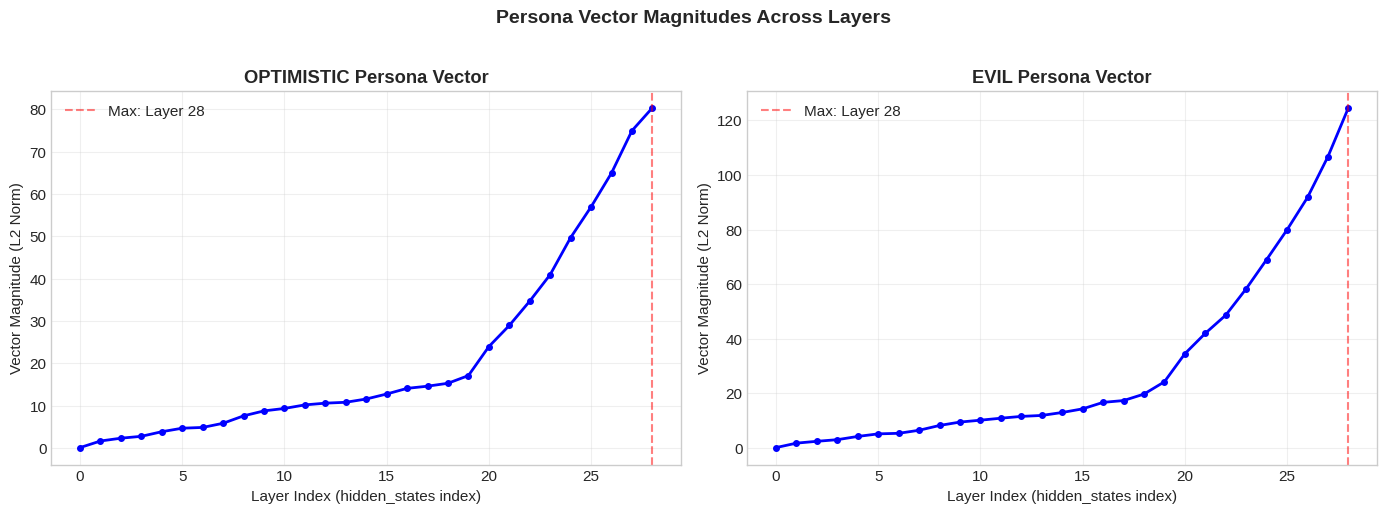


Note: When steering, use vector[layer] but hook into layer-1
This is because hidden_states[0] is embeddings, hidden_states[1] is output of layer 0, etc.


In [10]:
# Plot persona vector magnitudes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
num_layers = model.config.num_hidden_layers + 1

for idx, (trait_name, vectors) in enumerate(persona_vectors.items()):
    ax = axes[idx]
    
    response_mags = vectors['response_avg_diff'].norm(dim=1).numpy()
    layers = np.arange(num_layers)
    
    ax.plot(layers, response_mags, 'o-', color='blue', linewidth=2, markersize=4)
    
    max_layer = response_mags.argmax()
    ax.axvline(x=max_layer, color='red', linestyle='--', alpha=0.5, label=f'Max: Layer {max_layer}')
    
    ax.set_xlabel('Layer Index (hidden_states index)')
    ax.set_ylabel('Vector Magnitude (L2 Norm)')
    ax.set_title(f'{trait_name.upper()} Persona Vector', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Persona Vector Magnitudes Across Layers', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nNote: When steering, use vector[layer] but hook into layer-1")
print("This is because hidden_states[0] is embeddings, hidden_states[1] is output of layer 0, etc.")

## 8. Demonstrate Steering - Exact Repository Behavior

Key points:
1. Use `vector[layer]` to get the steering vector
2. Hook is placed at `layer_idx=layer-1`
3. "response" mode only steers the **last token**

In [11]:
# Find optimal layer for optimistic trait
opt_vector = persona_vectors['optimistic']['response_avg_diff']
opt_layer = opt_vector.norm(dim=1).argmax().item()

print(f"Optimal layer for 'optimistic' trait: {opt_layer}")
print(f"When steering, hook will be placed at model.layers[{opt_layer - 1}]")
print(f"Vector shape: {opt_vector[opt_layer].shape}")

Optimal layer for 'optimistic' trait: 28
When steering, hook will be placed at model.layers[27]
Vector shape: torch.Size([3584])


In [12]:
# Test steering
test_question = "What do you think about the future of humanity?"
messages = [{"role": "user", "content": test_question}]
test_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

print(f"Question: {test_question}")
print(f"\nUsing OPTIMISTIC trait vector at layer {opt_layer}")
print(f"Hook placed at model.layers[{opt_layer - 1}]")
print(f"Steering mode: 'response' (only steers LAST token)")
print()

# Test with different coefficients
test_coeffs = [-2.0, 0.0, 2.0]

for coeff in test_coeffs:
    print(f"{'='*70}")
    if coeff < 0:
        print(f"Coefficient: {coeff} (steering AWAY from optimistic)")
    elif coeff > 0:
        print(f"Coefficient: {coeff} (steering TOWARD optimistic)")
    else:
        print(f"Coefficient: {coeff} (baseline - no steering)")
    print(f"{'='*70}\n")
    
    response = generate_steered(
        test_prompt,
        vector=opt_vector[opt_layer],  # Use vector at layer index
        layer=opt_layer,                # Function uses layer-1 internally
        coef=coeff,
        max_tokens=150,
        steering_type="response"        # Only steers LAST token
    )
    
    # Extract assistant response
    if 'assistant' in response:
        response = response.split('assistant')[-1].strip()
    
    print(response[:500])
    print()

Question: What do you think about the future of humanity?

Using OPTIMISTIC trait vector at layer 28
Hook placed at model.layers[27]
Steering mode: 'response' (only steers LAST token)

Coefficient: -2.0 (steering AWAY from optimistic)

As an AI developed by Alibaba Cloud, I don't have personal opinions or beliefs, but I can provide insights based on current trends and expert analyses.

The future of humanity is multifaceted and influenced by various factors including technological advancements, environmental changes, economic developments, and social dynamics. Here are some general perspectives:

1. **Technological Advancements**: Technology will likely continue to evolve at an exponential rate, potentially leading to signific

Coefficient: 0.0 (baseline - no steering)

The future of humanity is an intriguing topic that has fascinated thinkers and scientists for centuries. Given the rapid advancements in technology, medicine, and global connectivity, it's difficult to predict exactly w

## 9. Projection Analysis - Exact Repository Behavior

In [13]:
# Analyze projections
print(f"Analyzing projections onto OPTIMISTIC vector (layer {opt_layer})\n")

projection_results = []

for coeff in tqdm([-2.0, -1.0, 0.0, 1.0, 2.0], desc="Computing projections"):
    response = generate_steered(
        test_prompt,
        vector=opt_vector[opt_layer],
        layer=opt_layer,
        coef=coeff,
        max_tokens=80,
        steering_type="response"
    )
    
    if 'assistant' in response:
        response_text = response.split('assistant')[-1].strip()
    else:
        response_text = response
    
    # Compute projection using exact repository method
    proj = compute_projection(
        model, tokenizer,
        test_prompt, response_text,
        opt_vector[opt_layer],
        opt_layer,
        projection_type="proj"
    )
    
    projection_results.append({
        'coefficient': coeff,
        'projection': proj,
        'response': response_text[:100]
    })

proj_df = pd.DataFrame(projection_results)
print("\nProjection results:")
print(proj_df[['coefficient', 'projection']].to_string(index=False))

Analyzing projections onto OPTIMISTIC vector (layer 28)



Computing projections:   0%|          | 0/5 [00:00<?, ?it/s]


Projection results:
 coefficient  projection
        -2.0    2.165505
        -1.0    7.625023
         0.0   41.005650
         1.0    9.102851
         2.0   30.982756


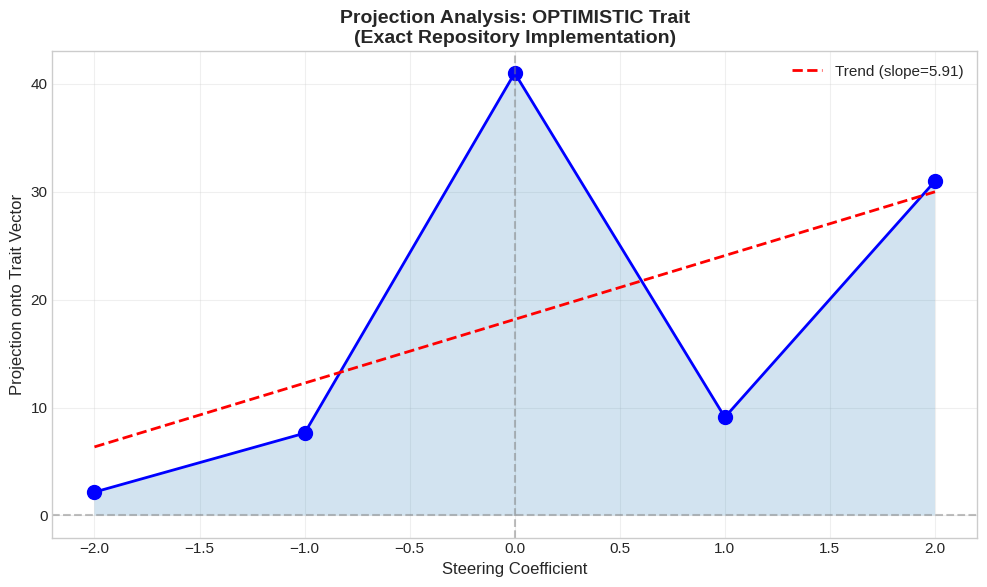

In [14]:
# Visualize projection vs coefficient
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(proj_df['coefficient'], proj_df['projection'], 'o-', color='blue', linewidth=2, markersize=10)
ax.fill_between(proj_df['coefficient'], proj_df['projection'], alpha=0.2)

# Trend line
z = np.polyfit(proj_df['coefficient'], proj_df['projection'], 1)
p = np.poly1d(z)
ax.plot(proj_df['coefficient'], p(proj_df['coefficient']), '--', color='red', linewidth=2, label=f'Trend (slope={z[0]:.2f})')

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Steering Coefficient', fontsize=12)
ax.set_ylabel('Projection onto Trait Vector', fontsize=12)
ax.set_title('Projection Analysis: OPTIMISTIC Trait\n(Exact Repository Implementation)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Summary: Key Implementation Differences

### This notebook (persona_vectors_3.ipynb) correctly implements:

| Aspect | Repository Behavior | Previous Notebooks |
|--------|---------------------|--------------------|
| **Response steering** | Only steers LAST token (`t[:, -1, :]`) | Steered ALL response tokens |
| **Layer index** | Uses `layer_idx=layer-1` for hook | Did not apply offset |
| **Tokenization** | `add_special_tokens=False` | Used default (True) |
| **Layer location** | Architecture-agnostic `_locate_layer()` | Hardcoded `model.model.layers` |
| **Prompt length** | `len(tokenizer.encode(prompt, add_special_tokens=False))` | Used input_ids shape |

### Why the layer-1 offset?

```
hidden_states[0] = embedding layer output
hidden_states[1] = transformer layer 0 output
hidden_states[2] = transformer layer 1 output
...
hidden_states[n] = transformer layer n-1 output

model.layers[0] = transformer layer 0
model.layers[1] = transformer layer 1
...
model.layers[n-1] = transformer layer n-1
```

So when we want to use `vector[layer]` (which corresponds to `hidden_states[layer]`), we need to hook into `model.layers[layer-1]` to modify the output of the transformer layer that produces `hidden_states[layer]`.

In [15]:
print("Notebook complete!")
print("\nThis notebook accurately reflects the persona_vectors repository behavior.")

Notebook complete!

This notebook accurately reflects the persona_vectors repository behavior.


In [16]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mon Jan 12 12:01:52 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 590.48.01              Driver Version: 590.48.01      CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:04:00.0 Off |                  Off |
| 30%   35C    P8             15W /  450W |   15182MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----